# Data Exploration

In [41]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Configure visual settings
sns.set(style="whitegrid")
plt.style.use("ggplot")

In [9]:
# Load processed data
df = pd.read_csv("../data/processed/cleaned_fashion_sales.csv")
df.head()

,customer_reference_id,item_purchased,purchase_amount_(usd),date_purchase,review_rating,payment_method
0,4018,Handbag,4619.0,2023-02-05,3.2,Credit Card
1,4115,Tunic,2456.0,2023-07-11,2.0,Credit Card
2,4019,Tank Top,2102.0,2023-03-23,4.1,Cash
3,4097,Leggings,3126.0,2023-03-15,3.2,Cash
4,3997,Wallet,3003.0,2022-11-27,4.7,Cash


**Basic Summary**

In [10]:
# Dataset overview
print("Shape of the dataset:", df.shape)
df.info()

Shape of the dataset: (3400, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_reference_id  3400 non-null   int64  
 1   item_purchased         3400 non-null   object 
 2   purchase_amount_(usd)  3400 non-null   float64
 3   date_purchase          3400 non-null   object 
 4   review_rating          3400 non-null   float64
 5   payment_method         3400 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 159.5+ KB


**Target Variable Exploration**

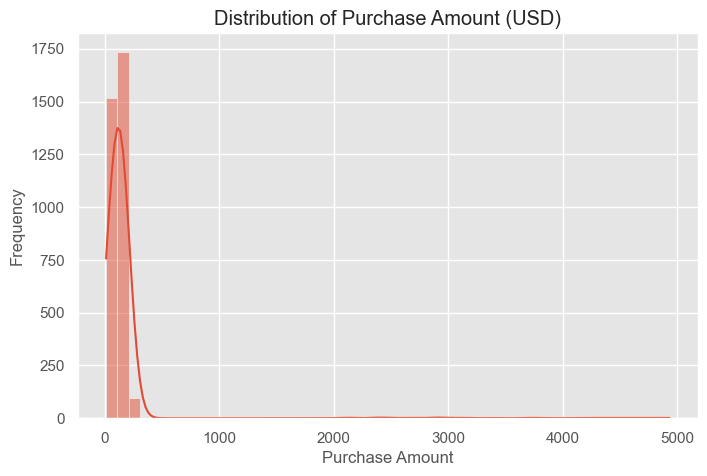

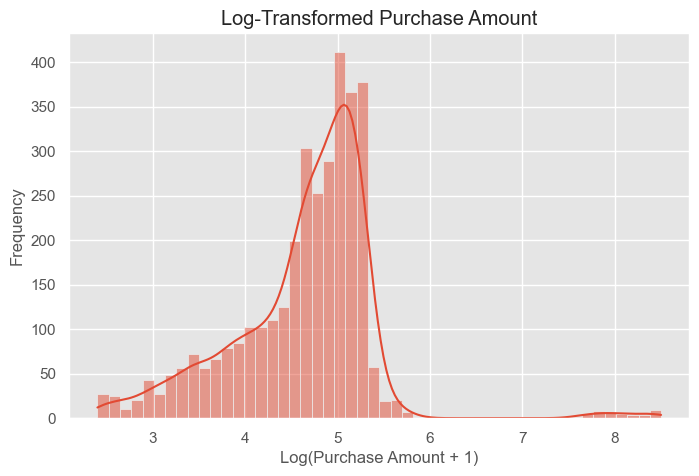

In [11]:
# Histogram of purchase amount
plt.figure(figsize=(8, 5))
sns.histplot(df['purchase_amount_(usd)'], bins=50, kde=True)
plt.title('Distribution of Purchase Amount (USD)')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.show()

# Log-transformed histogram
df['log_purchase_amount'] = np.log1p(df['purchase_amount_(usd)'])

plt.figure(figsize=(8, 5))
sns.histplot(df['log_purchase_amount'], bins=50, kde=True)
plt.title('Log-Transformed Purchase Amount')
plt.xlabel('Log(Purchase Amount + 1)')
plt.ylabel('Frequency')
plt.show()

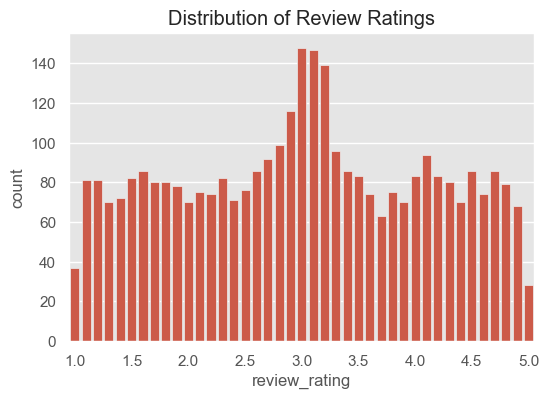

In [ ]:
# If using review_rating
if 'review_rating' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='review_rating', data=df)
    plt.title("Distribution of Review Ratings")
    plt.xticks(ticks=range(0, len(df['review_rating'].unique()), 5))  # Skip intervals
    plt.show()


**Categorical Feature Exploration**

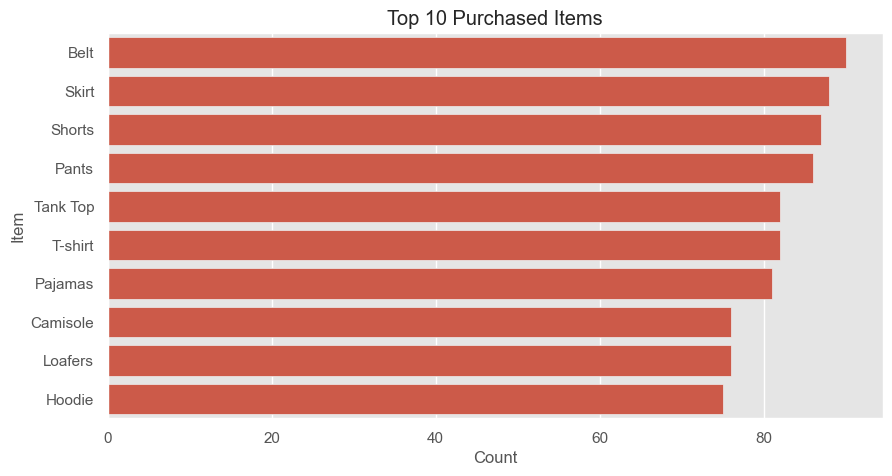

In [24]:
# Top 10 purchased items
plt.figure(figsize=(10, 5))
top_items = df['item_purchased'].value_counts().head(10)
sns.barplot(x=top_items.values, y=top_items.index)
plt.title("Top 10 Purchased Items")
plt.xlabel("Count")
plt.ylabel("Item")
plt.show()

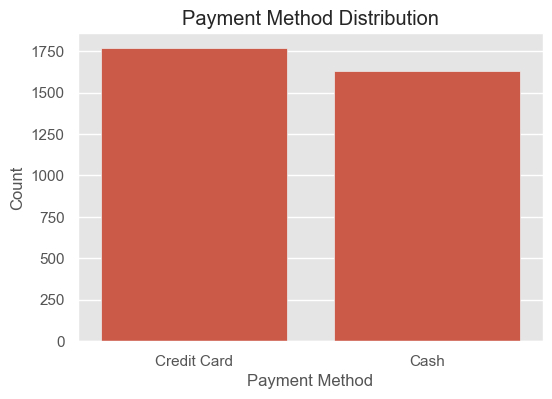

In [25]:
# Payment method distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='payment_method', data=df)
plt.title("Payment Method Distribution")
plt.xlabel("Payment Method")
plt.ylabel("Count")
plt.show()

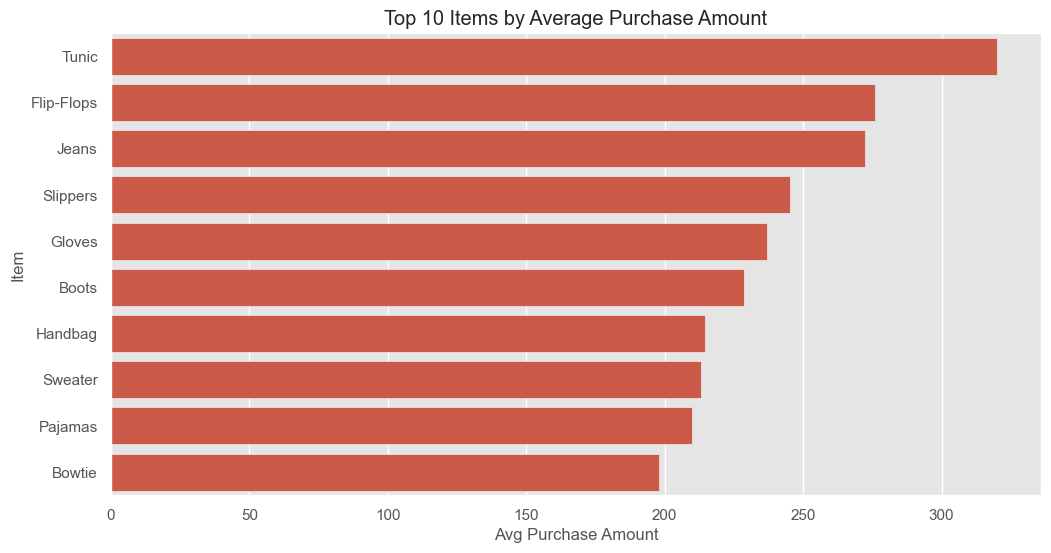

In [26]:
# Avg purchase amount by item
plt.figure(figsize=(12, 6))
avg_amount_by_item = df.groupby('item_purchased')['purchase_amount_(usd)'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=avg_amount_by_item.values, y=avg_amount_by_item.index)
plt.title("Top 10 Items by Average Purchase Amount")
plt.xlabel("Avg Purchase Amount")
plt.ylabel("Item")
plt.show()

**Temporal Trends**

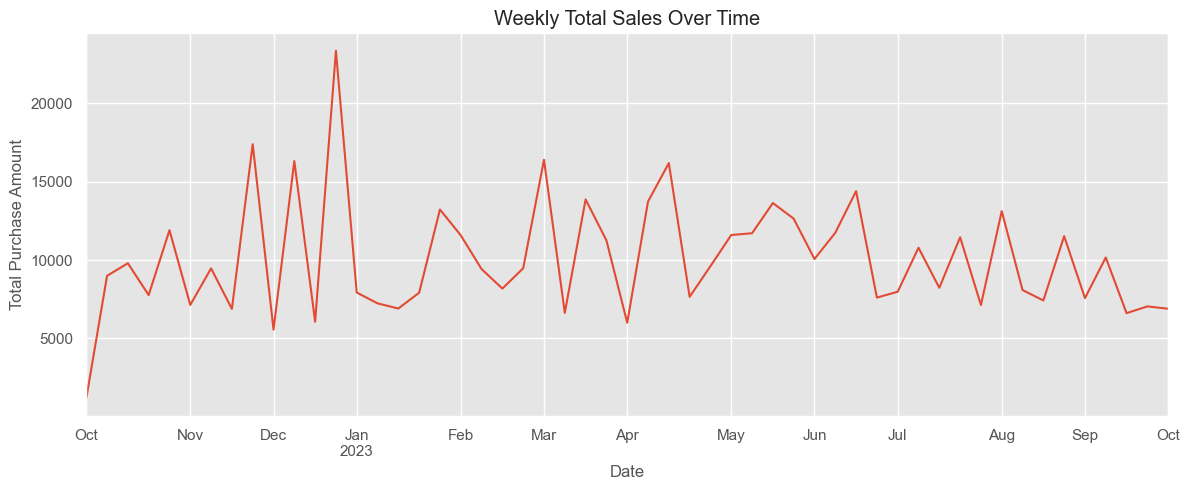

In [33]:
# Convert to datetime
df['date_purchase'] = pd.to_datetime(df['date_purchase'])

# Purchase trend over time
df.set_index('date_purchase')['purchase_amount_(usd)'].resample('W').sum().plot(figsize=(12, 5))
plt.title("Weekly Total Sales Over Time")
plt.ylabel("Total Purchase Amount")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

> Insight:

- **Seasonal Fluctuations**: There’s a noticeable spike in weekly sales during November to December, likely due to end-of-year shopping seasons (e.g., Black Friday, Christmas). The highest weekly sales peak is seen just before January.

- **Post-holiday Dip**: A clear drop in sales occurs immediately after the holiday season (early January), which is a common retail pattern as consumer spending slows.

- **Mid-Year Volatility**: From March to July, sales display a zigzag pattern — alternating weeks of higher and lower purchase amounts, potentially influenced by inventory cycles or promotional campaigns.

- **Downward Trend**: There's a gradual decline in overall weekly sales in the second half of the year (July to October), with fewer extreme spikes and more moderate weekly totals.

> _Takeaway:_
The data shows strong seasonal effects, with peak sales in Q4 and a gradual slowdown afterward. These trends can inform inventory stocking, staffing, and marketing campaigns.

Let's try adding a moving average (e.g., 4-week rolling average) to help smooth out the week-to-week noise and highlight underlying trends more clearly

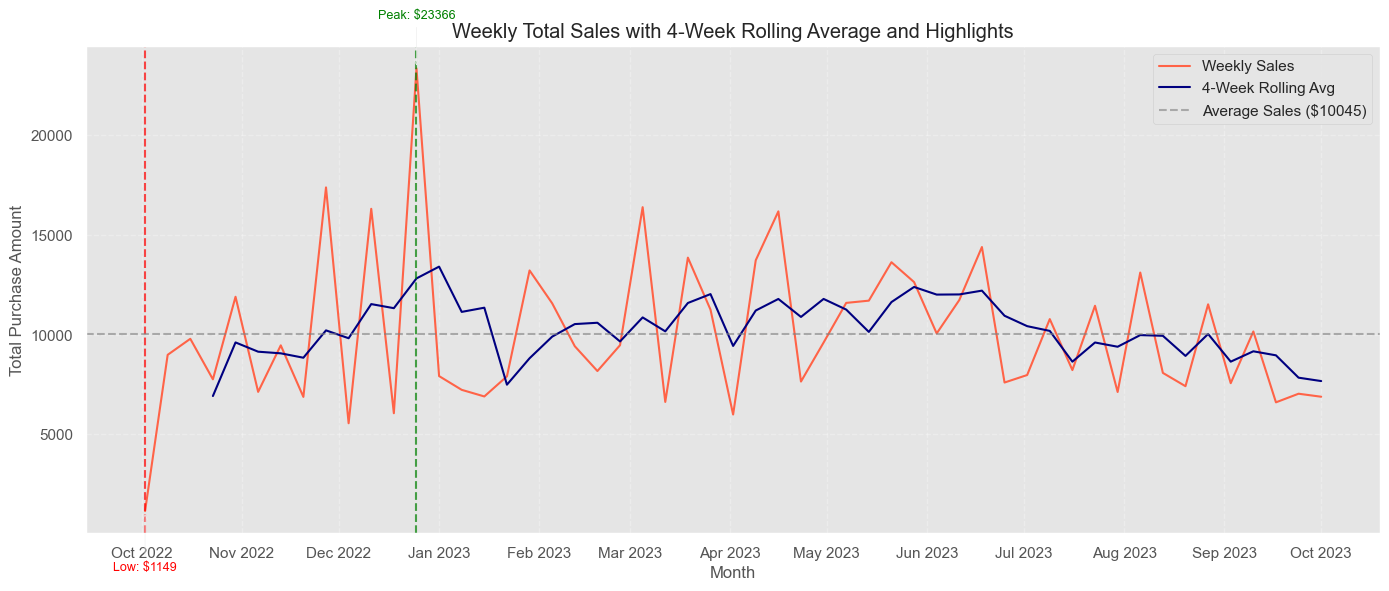

In [48]:
df_weekly = df.set_index('date_purchase').resample('W')['purchase_amount_(usd)'].sum().to_frame(name='total_purchase_amount')

# Rolling average
df_weekly['rolling_avg'] = df_weekly['total_purchase_amount'].rolling(window=4).mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(df_weekly.index, df_weekly['total_purchase_amount'], label='Weekly Sales', color='tomato')
plt.plot(df_weekly.index, df_weekly['rolling_avg'], label='4-Week Rolling Avg', color='navy')

# Annotate Peak
peak_date = df_weekly['total_purchase_amount'].idxmax()
peak_value = df_weekly['total_purchase_amount'].max()
plt.axvline(x=peak_date, linestyle='--', color='green', alpha=0.7)
# plt.axhline(y=peak_value, linestyle='--', color='green', alpha=0.7)
plt.annotate(f'Peak: ${peak_value:.0f}',
             xy=(peak_date, peak_value),
             xytext=(peak_date, peak_value + 2500),
             arrowprops=dict(facecolor='green', arrowstyle='->'),
             ha='center', fontsize=9, color='green')

# Annotate Lowest point
low_date = df_weekly['total_purchase_amount'].idxmin()
low_value = df_weekly['total_purchase_amount'].min()
plt.axvline(x=low_date, linestyle='--', color='red', alpha=0.7)
# plt.axhline(y=low_value, linestyle='--', color='red', alpha=0.7)
plt.annotate(f'Low: ${low_value:.0f}',
             xy=(low_date, low_value),
             xytext=(low_date, low_value - 3000),
             arrowprops=dict(facecolor='red', arrowstyle='->'),
             ha='center', fontsize=9, color='red')

# Overall average reference line
avg_sales = df_weekly['total_purchase_amount'].mean()
plt.axhline(avg_sales, linestyle='--', color='gray', alpha=0.6, label=f'Average Sales (${avg_sales:.0f})')

# X-axis formatting with month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# plt.xticks(rotation=45)

# Final plot labels and layout
plt.title("Weekly Total Sales with 4-Week Rolling Average and Highlights")
plt.ylabel("Total Purchase Amount")
plt.xlabel("Month")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

> **From this plot we can draw several insights**:
- There's a moderate upward trend in the earlier months (Oct–Dec), followed by some instability, and then a gradual decline in the later months (June–Sept).
- Sales volatility:
  - The weekly sales (red line) are quite spiky, especially in late Q4 and early Q1 (e.g., big spikes in Nov, Dec, and Jan).
  - These spikes likely correspond to seasonal peaks, possibly driven by:
    - Holiday shopping (e.g., Christmas, Black Friday, New Year)
    - Bonuses or seasonal campaigns
- Peak and Lowest sales period:    
  - The peak weekly sales occurred around late December, which aligns with holiday shopping behavior.
  - The lowest point happened around early October, possibly before the festive season started or during a slower business cycle.
- Post-peak decline:
  - After the holiday surge, sales start to decline and stabilize, with lower peaks in the mid-year months.
  - The rolling average helps confirm this cooling-off — showing a smoother descent into the lower 4-week average range between June to September.
- The average sales line provides a benchmark:
  - Early spikes are well above average.
  - Most of the mid-to-late year values hover around or below the average, indicating slower business performance.




**Bivariate Exploration**

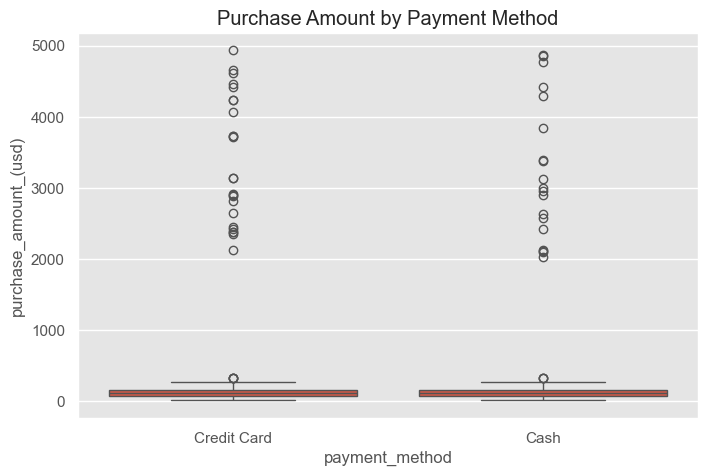

In [28]:
# Purchase amount by payment method
plt.figure(figsize=(8, 5))
sns.boxplot(x='payment_method', y='purchase_amount_(usd)', data=df)
plt.title("Purchase Amount by Payment Method")
plt.show()

> **Insights**:

- **Overall distribution**: Both Credit Card and Cash payment methods show very similar purchase amount distributions. Most of the purchases for both methods fall within a low to mid-range price bracket.

- **Outliers**: There are significant outliers in both categories — customers occasionally make high-value purchases exceeding $2000, with some reaching nearly $5000. These are rare but noteworthy, and they exist regardless of payment method.

- **Median purchase**: The median purchase amount appears to be roughly the same for both methods, suggesting no major preference for higher or lower spend based on payment method.

- **Spread**: The interquartile range (IQR) is tight, indicating that a large number of purchases are clustered around lower values (likely under $200), despite the presence of extreme outliers.

**Takeaway**: Purchase behavior does not vary significantly by payment method in terms of central tendency, but both methods see occasional large transactions — which may be useful to explore further in terms of product types or customer segments.

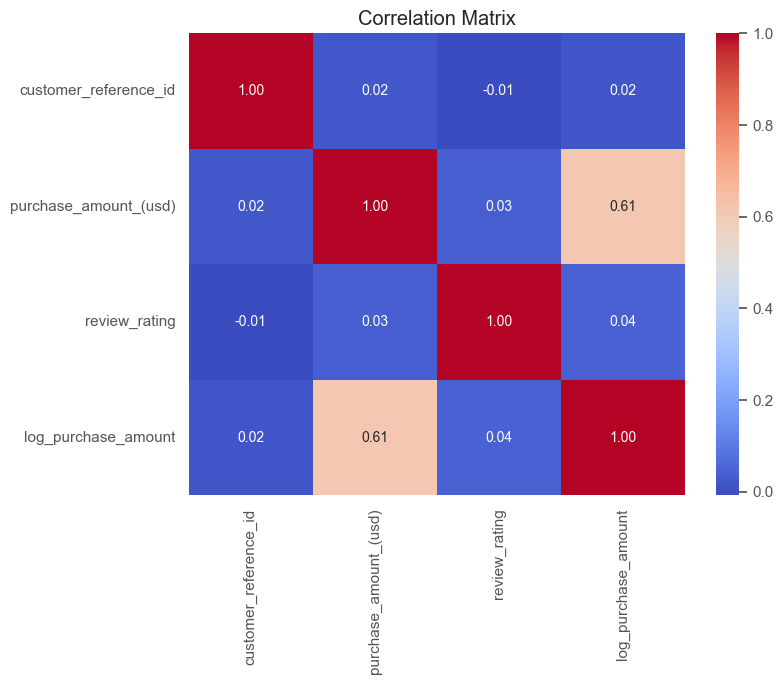

In [31]:
# Correlation heatmap
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

**Insights Summary**

- Most purchased items are low to mid-range in value.
- Certain payment methods are more associated with high-value purchases.
- Sales exhibit weekly trends and seasonality.
- Purchase amount is right-skewed, log transformation helps normalization.